### Federated Random Forest

In [1]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
# --------------------------------------------
# 1. Imports
# --------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib.backends.backend_pdf import PdfPages
import mpld3

# Set consistent styling
sns.set(style="white", font_scale=1.2)


In [3]:
# Federated_RF_Evaluation.ipynb

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import mpld3

# Setup
studies = ["SDY569", "SDY797", "SDY1737"]
standard_features = ["MIAA", "GAD65", "IA2IC", "ICA", "ZNT8", "8-12", "13-17", ">18", "Sex"]

# Output folders
os.makedirs("outputs/pdfs", exist_ok=True)
os.makedirs("outputs/html", exist_ok=True)

rf_results = {}

for study in studies:
    print(f"\n=== Training Random Forest for {study} ===")

    # --- Load Data ---
    df_train = pd.read_csv(f"data/cleaned/{study}_train.csv").fillna(0.0)
    df_test  = pd.read_csv(f"data/cleaned/{study}_test.csv").fillna(0.0)

    # Log-transform target
    df_train["log_auc"] = np.log(df_train["C_Peptide_AUC_4Hrs"])
    df_test["log_auc"]  = np.log(df_test["C_Peptide_AUC_4Hrs"])

    X_train = df_train[standard_features].values
    y_train = df_train["log_auc"].values
    X_test  = df_test[standard_features].values
    y_test  = df_test["log_auc"].values

    # --- Train Random Forest ---
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X_train, y_train)

    # --- Predict ---
    y_pred = rf_model.predict(X_test)

    # --- Evaluate ---
    squared_errors = (y_test - y_pred) ** 2
    mse = mean_squared_error(y_test, y_pred)
    median_mse = np.median(squared_errors)
    iqr = np.percentile(squared_errors, 75) - np.percentile(squared_errors, 25)

    print(f"  MSE:        {mse:.4f}")
    print(f"  Median MSE: {median_mse:.4f}")
    print(f"  IQR:        {iqr:.4f}")

    # --- Store results for downstream use ---
    rf_results[study] = {
        "model": rf_model,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "feature_names": standard_features,
        "train_df": df_train,
        "test_df": df_test,
        "mse": mse,
        "median_mse": median_mse,
        "iqr": iqr
    }



=== Training Random Forest for SDY569 ===
  MSE:        0.5322
  Median MSE: 0.2602
  IQR:        0.0257

=== Training Random Forest for SDY797 ===
  MSE:        0.2417
  Median MSE: 0.0551
  IQR:        0.3715

=== Training Random Forest for SDY1737 ===
  MSE:        0.5753
  Median MSE: 0.2308
  IQR:        0.5537


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import mpld3

# Setup
studies = ["SDY569", "SDY797", "SDY1737"]
standard_features = ["MIAA", "GAD65", "IA2IC", "ICA", "ZNT8", "8-12", "13-17", ">18", "Sex"]

# Output folders
os.makedirs("outputs/pdfs", exist_ok=True)
os.makedirs("outputs/html", exist_ok=True)

# Train per-study models
local_models = {}
split_data = {}

for study in studies:
    df_train = pd.read_csv(f"data/cleaned/{study}_train.csv").fillna(0.0)
    df_test = pd.read_csv(f"data/cleaned/{study}_test.csv").fillna(0.0)

    df_train["log_auc"] = np.log(df_train["C_Peptide_AUC_4Hrs"])
    df_test["log_auc"] = np.log(df_test["C_Peptide_AUC_4Hrs"])

    X_train = df_train[standard_features].values
    y_train = df_train["log_auc"].values
    X_test = df_test[standard_features].values
    y_test = df_test["log_auc"].values

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    local_models[study] = model
    split_data[study] = {"X_test": X_test, "y_test": y_test, "test_df": df_test.copy()}



Federated RF on SDY569
  MSE:        0.4507
  Median MSE: 0.0190
  IQR:        0.5434


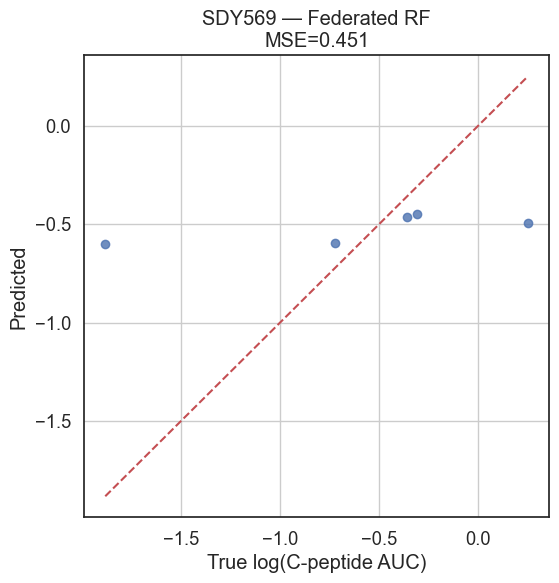


Federated RF on SDY797
  MSE:        0.2161
  Median MSE: 0.0535
  IQR:        0.2244


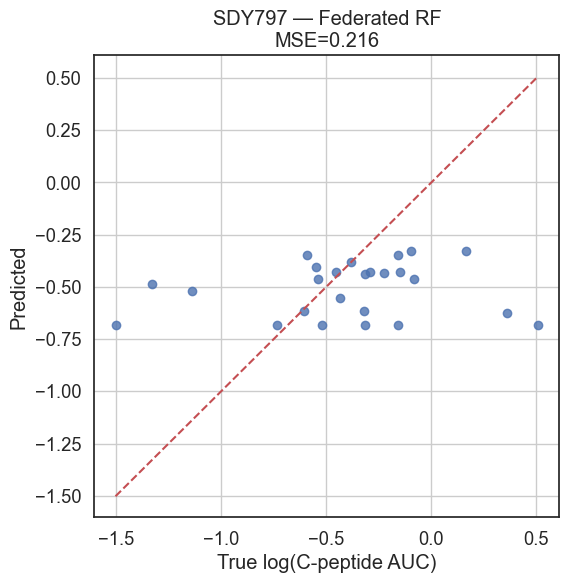


Federated RF on SDY1737
  MSE:        0.5329
  Median MSE: 0.0949
  IQR:        0.1942


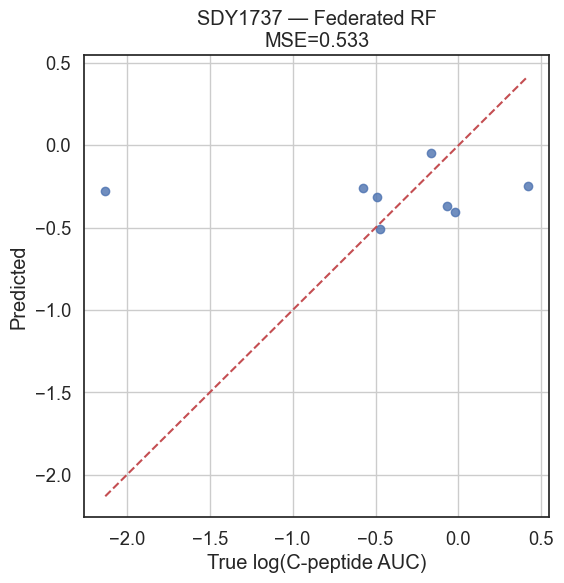

In [5]:
# Federated prediction (ensembled)
rf_results_federated = {}

for study in studies:
    X_test = split_data[study]["X_test"]
    y_test = split_data[study]["y_test"]

    preds_all = np.stack([model.predict(X_test) for model in local_models.values()])
    avg_pred = preds_all.mean(axis=0)

    mse = mean_squared_error(y_test, avg_pred)
    median_mse = np.median((y_test - avg_pred)**2)
    iqr = np.percentile((y_test - avg_pred)**2, 75) - np.percentile((y_test - avg_pred)**2, 25)

    print(f"\nFederated RF on {study}")
    print(f"  MSE:        {mse:.4f}")
    print(f"  Median MSE: {median_mse:.4f}")
    print(f"  IQR:        {iqr:.4f}")

    rf_results_federated[study] = {
        "y_test": y_test,
        "y_pred": avg_pred,
        "test_df": split_data[study]["test_df"],
        "mse": mse
    }

    # XY Scatter Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, avg_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True log(C-peptide AUC)")
    plt.ylabel("Predicted")
    plt.title(f"{study} — Federated RF\nMSE={mse:.3f}")
    plt.grid(True)
    plt.savefig(f"outputs/pdfs/{study}_rf_federated_scatter.pdf")
    plt.show()

    # Save as interactive HTML
    df_plot = pd.DataFrame({"True": y_test, "Predicted": avg_pred})
    fig = px.scatter(df_plot, x="True", y="Predicted", title=f"{study} — Federated RF")
    fig.add_shape(type="line",
        x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max(),
        line=dict(color="red", dash="dash"))
    fig.write_html(f"outputs/html/{study}_rf_federated_scatter.html")

#

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm

# ----------------------------
# Setup
# ----------------------------
os.makedirs("outputs/pdfs", exist_ok=True)
os.makedirs("outputs/html", exist_ok=True)

severity_colors = {
    "Severe": "#d73027",
    "Moderate": "#fc8d59",
    "Mild": "#91bfdb",
}

features = ["MIAA", "GAD65", "IA2IC", "ICA", "ZNT8", "8-12", "13-17", ">18", "Sex"]

# Store residuals for all studies for boxplot
residuals_all = []

# ----------------------------
# Loop through studies
# ----------------------------
for study in studies:
    print(f"\n=== Generating heatmap for {study} ===")

    # --- Load prediction results ---
    result = rf_results_federated[study]  # or rf_results if not federated
    df = result["test_df"].copy()
    df["True_log_auc"] = result["y_test"]
    df["Pred_log_auc"] = result["y_pred"]
    df["AbsError"] = np.abs(df["True_log_auc"] - df["Pred_log_auc"])
    df["Residual"] = df["True_log_auc"] - df["Pred_log_auc"]
    df.index = [f"{study}_P{i}" for i in range(len(df))]

    # --- Save residuals for boxplot ---
    for res in df["Residual"]:
        residuals_all.append({"Study": study, "Residual": res})


=== Generating heatmap for SDY569 ===

=== Generating heatmap for SDY797 ===

=== Generating heatmap for SDY1737 ===


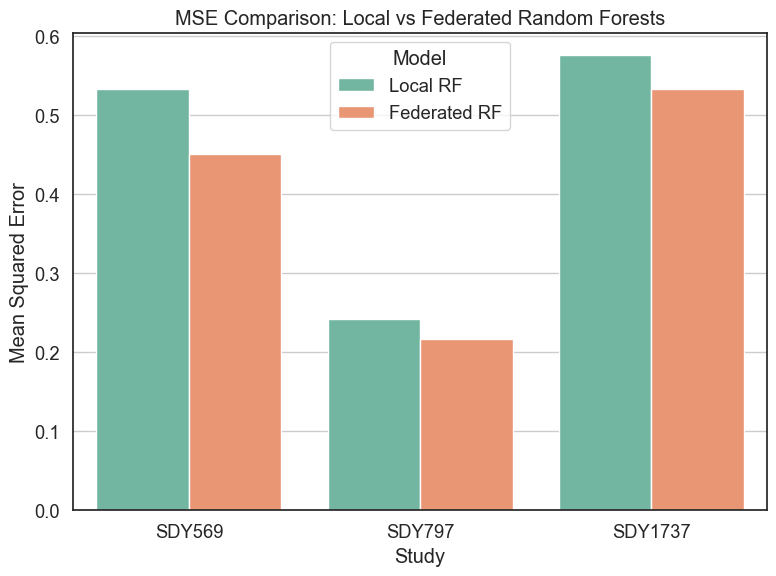

✅ MSE comparison saved to PDF and HTML.


In [7]:
# ================================
#  FINAL COMPARISON PLOT: MSE
# ================================
local_mse = []
federated_mse = []

for study in studies:
    mse_local = rf_results[study]["mse"]
    mse_fed = rf_results_federated[study]["mse"]
    local_mse.append(mse_local)
    federated_mse.append(mse_fed)

# Create DataFrame for seaborn
df_mse = pd.DataFrame({
    "Study": studies * 2,
    "MSE": local_mse + federated_mse,
    "Model": ["Local RF"] * len(studies) + ["Federated RF"] * len(studies)
})

# --- Bar Plot ---
plt.figure(figsize=(8, 6))
sns.barplot(data=df_mse, x="Study", y="MSE", hue="Model", palette="Set2")
plt.title("MSE Comparison: Local vs Federated Random Forests")
plt.ylabel("Mean Squared Error")
plt.grid(axis="y")
plt.tight_layout()

# Save PDF and HTML
plt.savefig("outputs/pdfs/MSE_comparison_local_vs_federated.pdf")

import plotly.express as px
fig = px.bar(df_mse, x="Study", y="MSE", color="Model", barmode="group",
             title="MSE Comparison: Local vs Federated RF",
             text_auto=".3f", height=500)
fig.write_html("outputs/html/MSE_comparison_local_vs_federated.html")

plt.show()
print("✅ MSE comparison saved to PDF and HTML.")


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_4253/299410440.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




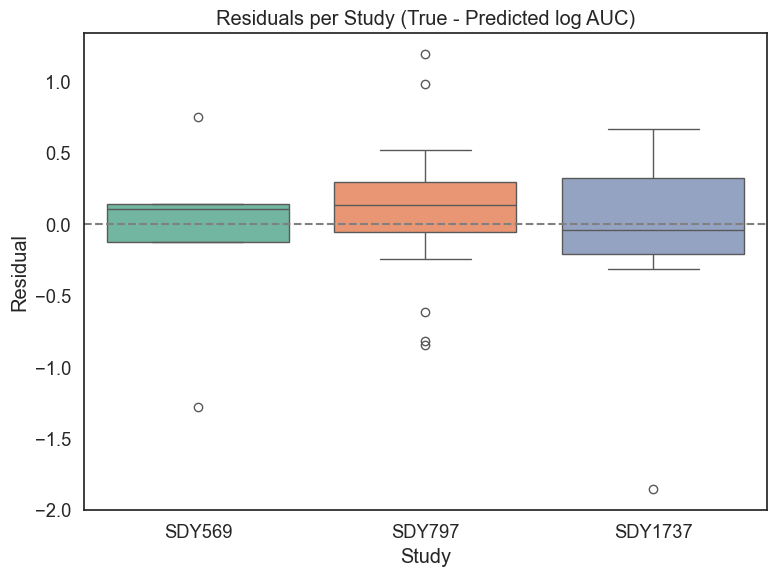

In [8]:
# --- Convert to DataFrame ---
residuals_df = pd.DataFrame(residuals_all)

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=residuals_df, x="Study", y="Residual", palette="Set2")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals per Study (True - Predicted log AUC)")
plt.ylabel("Residual")
plt.xlabel("Study")
plt.tight_layout()
plt.savefig("outputs/pdfs/residuals_boxplot.pdf")
plt.show()



Generating heatmap for SDY797 (Federated RF)


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_4253/762762724.py:41: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Saved PDF to outputs/pdfs/federated_SDY797_heatmap.pdf

Generating heatmap for SDY569 (Federated RF)
Saved PDF to outputs/pdfs/federated_SDY569_heatmap.pdf

Generating heatmap for SDY1737 (Federated RF)


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_4253/762762724.py:41: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_4253/762762724.py:41: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Saved PDF to outputs/pdfs/federated_SDY1737_heatmap.pdf


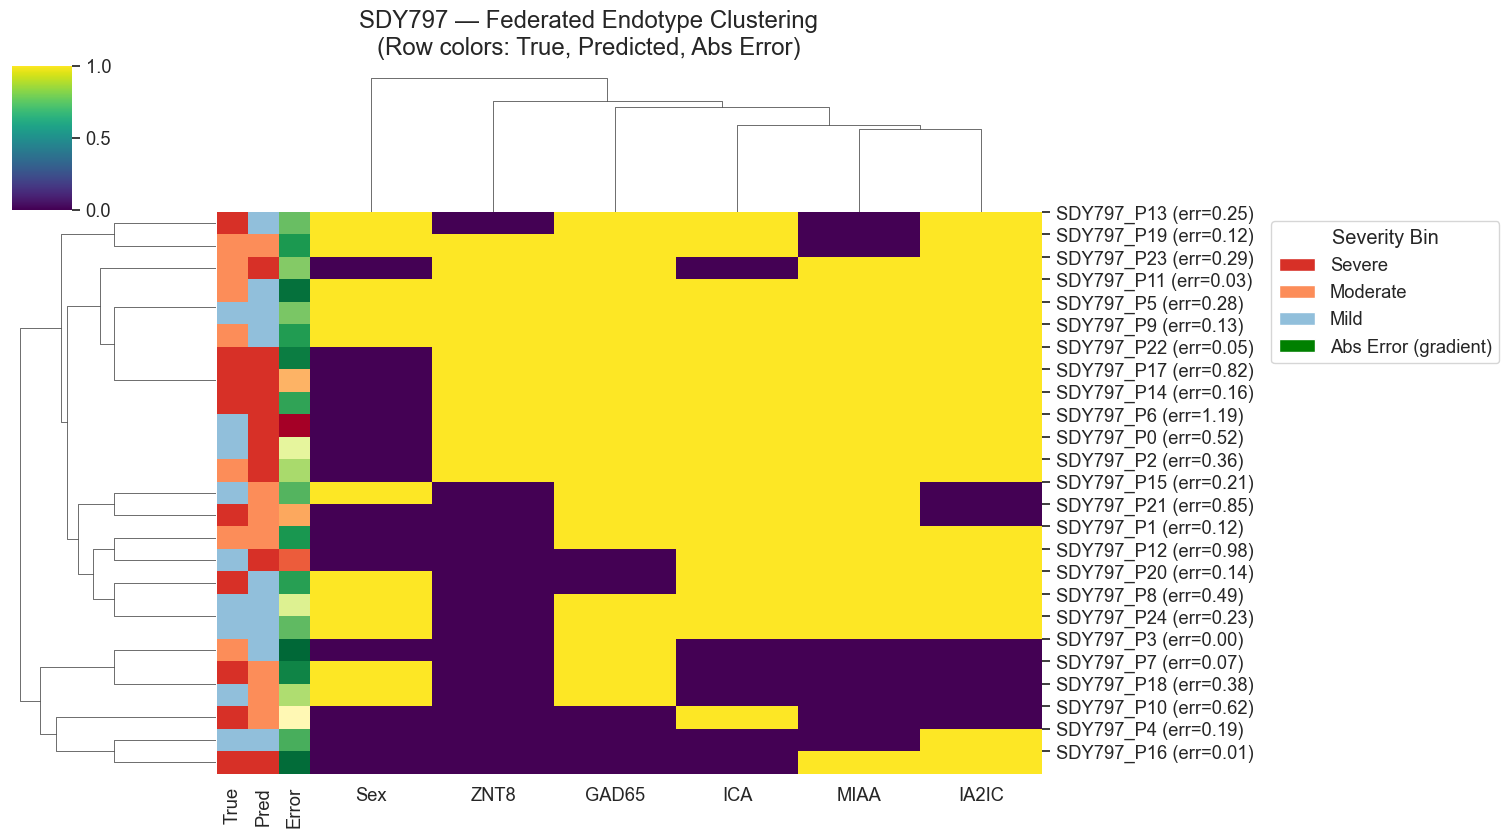

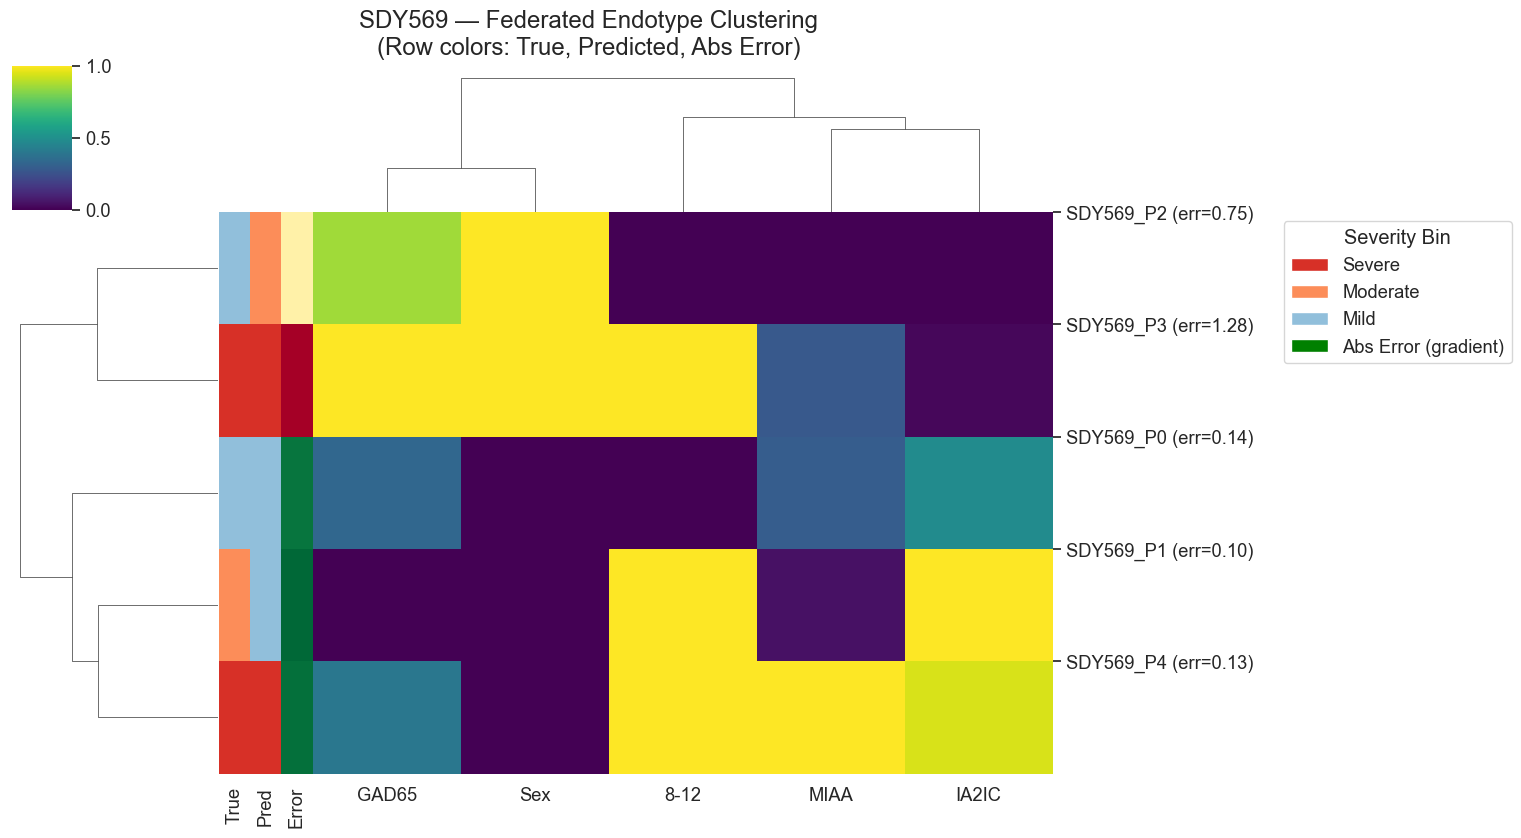

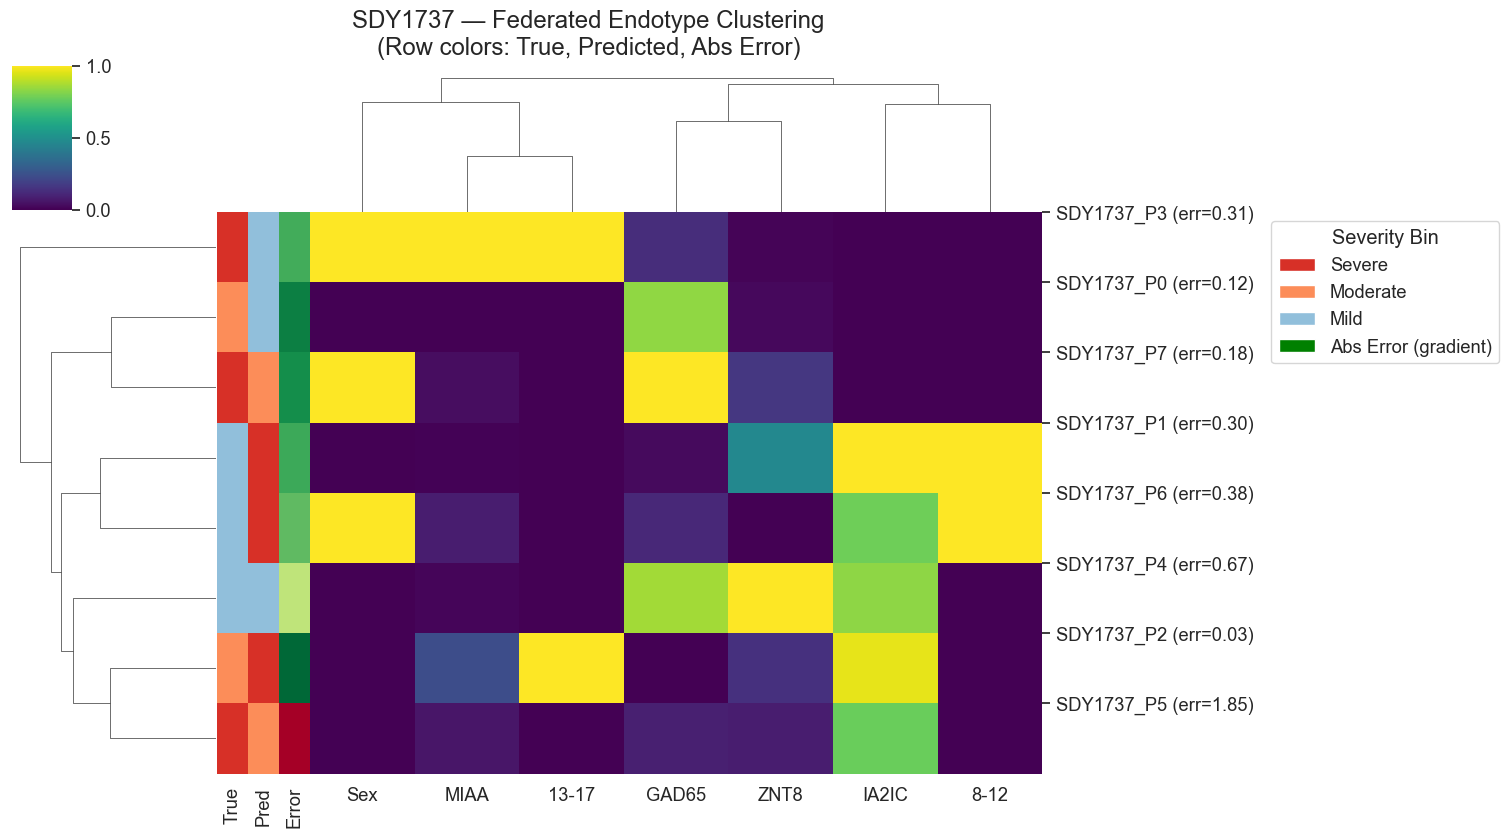

In [9]:
# -----------------------
# HEATMAP VISUALIZATION
# -----------------------

severity_colors = {
    "Severe": "#d73027",
    "Moderate": "#fc8d59",
    "Mild": "#91bfdb",
}

for study in ["SDY797","SDY569","SDY1737"]:
    print(f"\nGenerating heatmap for {study} (Federated RF)")

    result = rf_results_federated[study]
    df = result["test_df"].copy()
    df["True_log_auc"] = result["y_test"]
    df["Pred_log_auc"] = result["y_pred"]
    df["AbsError"] = np.abs(df["True_log_auc"] - df["Pred_log_auc"])
    df.index = [f"{study}_P{i}" for i in range(len(df))]

    # --- Prepare matrix ---
    features = standard_features
    X = df[features].copy()

    for col in ["8-12", "13-17", ">18", "Sex"]:
        if col in X.columns:
            X[col] = X[col].astype(float)

    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0).replace([np.inf, -np.inf], 0.0)
    X = X.loc[:, X.var() > 0]

    # --- Binning severity ---
    df["SeverityTrueBin"] = pd.qcut(df["True_log_auc"], 3, labels=["Severe", "Moderate", "Mild"])
    df["SeverityPredBin"] = pd.qcut(df["Pred_log_auc"], 3, labels=["Severe", "Moderate", "Mild"])

    # --- Normalize error for coloring ---
    import matplotlib.colors as mcolors
    
    # Normalized error for color mapping
    norm_error = (df["AbsError"] - df["AbsError"].min()) / (df["AbsError"].max() - df["AbsError"].min())
    error_cmt = plt.cm.get_cmap("RdYlGn_r")  # green=low error, red=high error
    # Convert normalized values to hex color strings using the coolwarm colormap
#    error_colors = [mcolors.to_hex(c) for c in plt.cm.coolwarm(norm_error)]
    error_colors = [mcolors.to_hex(c) for c in error_cmt(norm_error)]

    # Assemble DataFrame with 3 color bands: True, Predicted, Error
    row_colors = pd.DataFrame({
        "True": df["SeverityTrueBin"].map(severity_colors),
        "Pred": df["SeverityPredBin"].map(severity_colors),
        "Error": error_colors
    }, index=df.index)
    
    
    # --- Row labels with error ---
    labels = [f"{idx} (err={err:.2f})" for idx, err in zip(df.index, df["AbsError"])]

    # --- Clustermap ---
    g = sns.clustermap(
        X,
        cmap="viridis",  # Updated to match your example
        row_colors=row_colors,
        figsize=(12, 8),
        col_cluster=True,
        row_cluster=True,
        standard_scale=1
    )
    # After clustermap is create
    reordered = g.dendrogram_row.reordered_ind
    
    # Use X.index, not df.index
    ordered_index = X.index[reordered]
    
    # Build labels from ordered rows
    ordered_labels = [
        f"{pid} (err={df.loc[pid, 'AbsError']:.2f})"
        for pid in ordered_index
    ]
    
    # Now assign labels safely
    g.ax_heatmap.set_yticks(np.arange(len(ordered_labels)))
    g.ax_heatmap.set_yticklabels(ordered_labels, rotation=0)

    # --- Legend ---
    severity_patches = [Patch(facecolor=color, label=label) for label, color in severity_colors.items()]
    error_patch = Patch(facecolor='green', label="Abs Error (gradient)")

    g.ax_heatmap.legend(
        handles=severity_patches + [error_patch],
        title="Severity Bin",
        bbox_to_anchor=(1.3, 1),
        loc="upper left"
    )

    plt.suptitle(f"{study} — Federated Endotype Clustering\n(Row colors: True, Predicted, Abs Error)", y=1.05)

    # --- Save as PDF ---
    pdf_path = f"outputs/pdfs/federated_{study}_heatmap.pdf"
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(g.fig, bbox_inches='tight')
    print(f"Saved PDF to {pdf_path}")

    # --- Optional: Save HTML placeholder ---
    from matplotlib.backends.backend_pdf import PdfPages
    import mpld3
    # Save interactive HTML
    with open(f"federated_{study}_heatmap.html", "w") as f:
        f.write(mpld3.fig_to_html(g.fig))



In [11]:
rf_results_retrained = {}

for study in studies:
    print(f"\n=== Retraining {study} using Federated Predictions ===")
    
    # Get training data
    df_train = rf_results[study]["train_df"].copy()
    X_train = df_train[standard_features].values
    
    # Make federated prediction on training set
    # Average predictions from all *other* studies (leave-one-out to avoid leakage)
    other_models = [m for k, m in rf_results_federated.items() if k != study]
    preds_train = np.stack([model["model"].predict(X_train) for model in other_models])
    y_train_fed = preds_train.mean(axis=0)
    
    # Train model using federated pseudo-labels
    rf_retrained = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)
    rf_retrained.fit(X_train, y_train_fed)

    # Evaluate on original test set
    X_test = rf_results[study]["X_test"]
    y_test = rf_results[study]["y_test"]
    y_pred = rf_retrained.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"  MSE after retraining: {mse:.4f}")
    
    rf_results_retrained[study] = {
        "model": rf_retrained,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "mse": mse,
        "train_df": df_train,
        "test_df": rf_results[study]["test_df"]
    }



=== Retraining SDY569 using Federated Predictions ===


KeyError: 'model'